In [1]:
import sys
import os

#Use if working on Colab
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/My Drive/PPM_Stability/'

#If working locally
PATH = os.getcwd()
sys.path.append(PATH)

In [2]:
#!pip install --upgrade numpy

In [3]:
from DatasetManager import DatasetManager

import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

from sklearn.metrics import accuracy_score
#import tensorflow as tf
#tf.keras.compat.disable_v2_backend()
from tensorflow.keras.backend import print_tensor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Flatten, Input
from keras.layers import LSTM
from keras.optimizers import Nadam, RMSprop
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
import math

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
sns.set_theme("paper", "darkgrid")
sns.set_palette("gray")

In [5]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])
    #print(dataset_manager.get_class_ratio(dataset_manager.read_dataset()))    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            #print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            

            if "lstm" not in method: 
                y_train = dataset_manager.get_label_numeric(dt_train_bucket)
                y_test = dataset_manager.get_label_numeric(dt_test_bucket)
            
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                #print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                #print("\tPositives in testing set:", test_pos_ratio)
                
                feat_comb_path = os.path.join(folder_loc, "bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (bucketID))
                with open (feat_comb_path, 'rb') as f:
                    feature_combiner = joblib.load(f)
                
                train_x = feature_combiner.transform(dt_train_bucket)
                test_x = feature_combiner.transform(dt_test_bucket)
                vector_length = test_x[0].shape
                
#                 print("Training instances:", len(y_train))
#                 print("Testing instances:", len(y_test))
#                 print("Feature Vector Length:", vector_length)
                
            else:
                y_train_path = os.path.join(folder_loc, "train_data/bucket_%s_labels.pickle" % (bucketID))
                with open (y_train_path, 'rb') as f:
                    train_y = pickle.load(f)

                y_test_path = os.path.join(folder_loc, "test_data/bucket_%s_labels.pickle" % (bucketID))
                with open (y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                
                y_train = [int(np.where(i==1)[0]) for i in train_y]
                y_test = test_y
               
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                #print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                #print("\tPositives in testing set:", test_pos_ratio)
                
                vector_length = dt_test_bucket[0].shape
                
#                 print("Training instances:", len(y_train))
#                 print("Testing instances:", len(y_test))
#                 print("Feature Vector Length:", vector_length)

production
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index
sepsis_cases
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index
bpic2012
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index


production
xgboost_single_agg


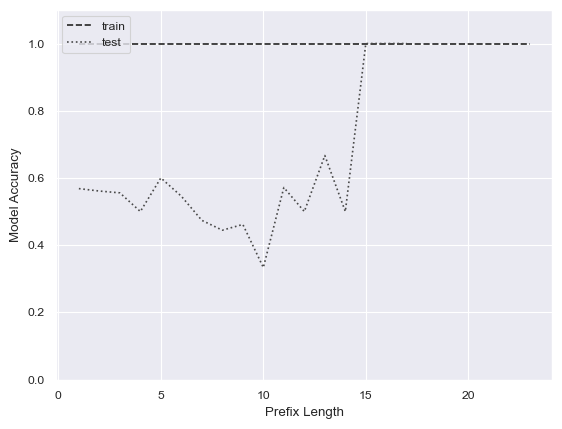

xgboost_prefix_agg


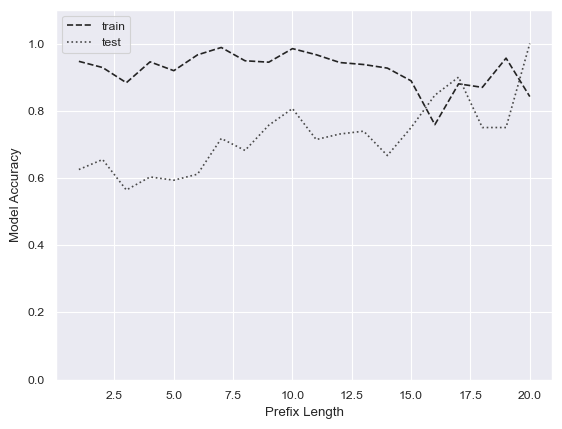

xgboost_prefix_index


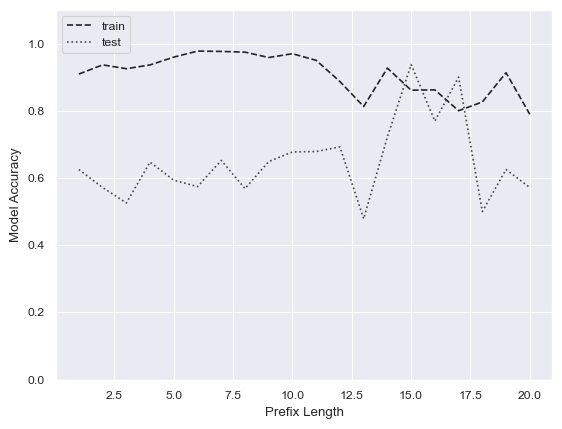

sepsis_cases
xgboost_single_agg


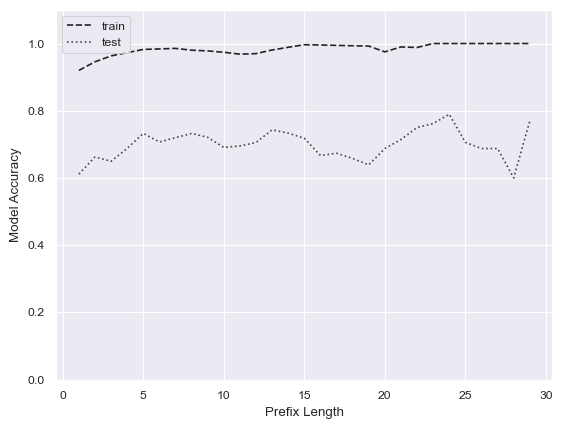

xgboost_prefix_agg


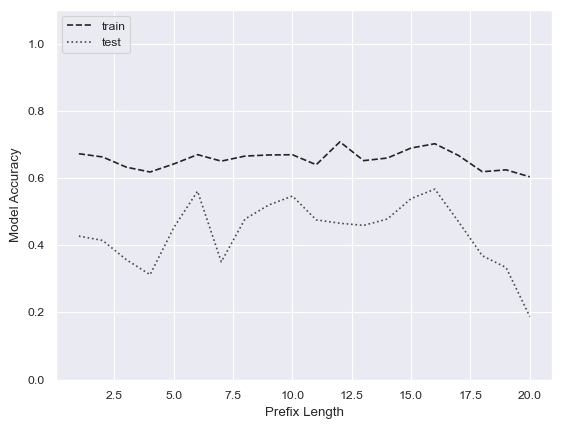

xgboost_prefix_index


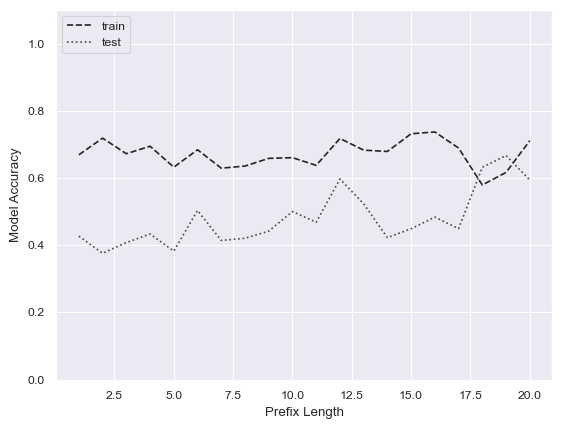

bpic2012
xgboost_single_agg


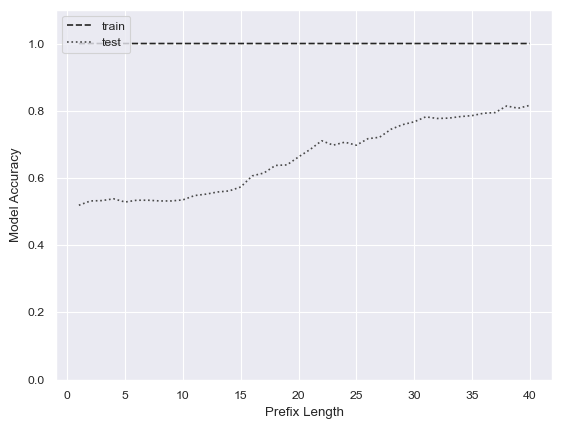

xgboost_prefix_agg


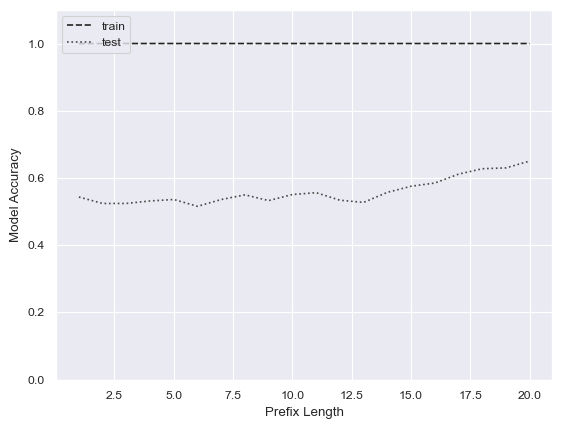

xgboost_prefix_index


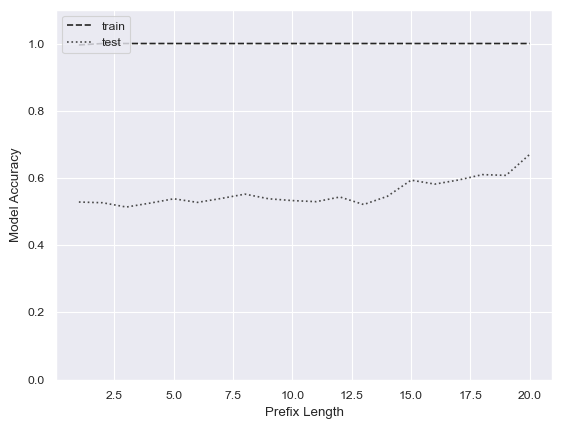

In [6]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
titles = {"production": "Production: ", "sepsis_cases": "Sepsis Cases: ", "bpic2012": "BPIC2012: ",
         "xgboost_single_agg": "Single Bucket & Aggregate Encoding", "xgboost_prefix_agg": "Prefix-Length Buckets \n& Aggregate Encoding",
         "xgboost_prefix_index": "Prefix-Length Buckets \n& Index-Based Encoding"}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = 20#len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        train_lengths = []
        train_predictions = []
        train_y_all = []
        
        test_lengths = []
        test_predictions = []
        test_y_all = []
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            #print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            

            if "lstm" not in method: 
                y_train = dataset_manager.get_label_numeric(dt_train_bucket)
                y_test = dataset_manager.get_label_numeric(dt_test_bucket)
            
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                #print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                #print("\tPositives in testing set:", test_pos_ratio)
                
                pipeline_path = os.path.join(folder_loc, "pipelines/pipeline_bucket_%s.joblib" % (bucketID))
                with open (pipeline_path, 'rb') as f:
                    pipeline = joblib.load(f)
                
                prefix_lengths = dataset_manager.get_prefix_lengths(dt_train_bucket)             
                train_lengths.extend(prefix_lengths.values)
                
                prefix_lengths = dataset_manager.get_prefix_lengths(dt_test_bucket)             
                test_lengths.extend(prefix_lengths.values)
                
                train_preds = pipeline.predict(dt_train_bucket)
                train_predictions.extend(train_preds)
                
                test_preds = pipeline.predict(dt_test_bucket)
                test_predictions.extend(test_preds)
                
                train_y_all.extend(y_train)
                test_y_all.extend(y_test)
            
        lens = list(set(train_lengths))
        train_accs = []
        test_accs = []
        for i in lens:
            idxs = [n for n in range(len(train_lengths)) if train_lengths[n] == i]
            preds = [train_predictions[n] for n in idxs]
            actual = [train_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            train_accs.append(accuracy)
            
            idxs = [n for n in range(len(test_lengths)) if test_lengths[n] == i]
            preds = [test_predictions[n] for n in idxs]
            actual = [test_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            test_accs.append(accuracy)


        plt.plot(lens, train_accs, '--', label = 'train')#, color = 'black')
        plt.plot(lens, test_accs, ':', label = 'test')#, color = 'grey')
        plt.legend(loc = "upper left")
        plt.xlabel("Prefix Length")
        plt.ylabel("Model Accuracy")
        plt.ylim(0,1.1)
        #plt.title(titles[data]+titles[method])
        title = "%s_%s_accuracy.pdf"%(data, method)
        plt.savefig("figures/"+title, format="pdf")
        plt.show()
        
        train_acc = accuracy_score(train_y_all, train_predictions)
        #print("\tTraining accuracy:", train_acc)
        
        train_pos_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 1]
        actual = [train_y_all[i] for i in train_pos_idx]
        preds = [train_predictions[i] for i in train_pos_idx]
        train_pos_acc = accuracy_score(actual, preds)
        #print("\t\tTraining accuracy - Positives:", train_pos_acc)
        
        train_neg_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 0]
        actual = [train_y_all[i] for i in train_neg_idx]
        preds = [train_predictions[i] for i in train_neg_idx]
        train_neg_acc = accuracy_score(actual, preds)
        #print("\t\tTraining accuracy - Negatives:", train_neg_acc)
        
        test_acc = accuracy_score(test_y_all, test_predictions)
        #print("\tTesting accuracy:", test_acc)
        
        test_pos_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 1]
        actual = [test_y_all[i] for i in test_pos_idx]
        preds = [test_predictions[i] for i in test_pos_idx]
        test_pos_acc = accuracy_score(actual, preds)
        #print("\t\tTesting accuracy - Positives:", test_pos_acc)
        
        test_neg_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 0]
        actual = [test_y_all[i] for i in test_neg_idx]
        preds = [test_predictions[i] for i in test_neg_idx]
        test_neg_acc = accuracy_score(actual, preds)
        #print("\t\tTesting accuracy - Negatives:", test_neg_acc)
            
        #break
                

In [ ]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_feat_lens = []
all_explainers = []
all_times = []
all_datasets = []
all_methods = []

data_dict = {"Prefix lengths": all_pref_lens, "Feature vector sizes": all_feat_lens, "Explainer": all_explainers,
       "Running time": all_times, "Dataset": all_datasets, "Method": all_methods}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        all_timing_path = os.path.join(folder_loc, "all_timing.csv")
        all_data = pd.read_csv(all_timing_path)
        
        all_pref_lens.extend(pd.Series(all_data['Prefix Length']))
        all_feat_lens.extend(pd.Series(all_data['Feature Vector Length']))
        all_explainers.extend(pd.Series(all_data['Explainer']))
        all_times.extend(pd.Series(all_data['Running Time']))
        
        all_datasets.extend([data]*all_data.shape[0])
        all_methods.extend([method]*all_data.shape[0])
        
comb_data = pd.DataFrame(data_dict)
#sns.set_style('darkgrid')
grid = sns.FacetGrid(comb_data, row = 'Dataset', col = 'Method', hue = 'Explainer', 
                     legend_out = True, height = 3.5, aspect = 1)
grid.map(sns.scatterplot, "Prefix lengths", "Running time", size= comb_data["Feature vector sizes"])
grid.set_axis_labels("Prefix lengths", "Running Time")
grid.add_legend()
plt.show()

In [ ]:
size_dict = {}
for data in datasets:
    size_dict[data] = {}
    data_data = comb_data[comb_data['Dataset'] == data]
    for each in methods:
        size_dict[data][each] = {}
        method_data = data_data[data_data['Method'] == each]
        keys = [str(i) for i in method_data['Prefix lengths'].unique()]
        for key in keys:
            length = [i for i in method_data[method_data['Prefix lengths'] == int(key)]['Feature vector sizes']][0]
            size_dict[data][each][key] = length

In [ ]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_feat_vec = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens, 'Feature Vector Sizes': all_feat_vec}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        feat_vec = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
                
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['lime_stability'])
                #bucket_tree_shap_stability = pd.Series(results['tree_shap_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                #tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for length in nr_events:
            feat_vec.append(size_dict[data][method][str(length)])
        
        plot_lens = list(set(nr_events))
        plot_vecs = [size_dict[data][method][str(i)] for i in plot_lens]
        
        fig, ax = plt.subplots()
        ax.plot(nr_events, lime_stability, 'ro', label = "LIME")
        ax2 = ax.twinx()
        ax2.plot(plot_lens, plot_vecs, label = "Feature Vector")
        ax.set_xlabel("Prefix Length")
        ax.set_ylabel("Stability")
        ax.set_ylabel("Feature Vector Size")
        ax.set_ylim(0, 1)
        ax2.invert_yaxis()
        plt.show()
        
        
        #for i in range(2):
        all_pref_lens.extend(nr_events)
        all_proba.extend(proba)
        all_datasets.extend([data]*len(nr_events))
        all_methods.extend([method]*len(nr_events))
        all_feat_vec.extend(feat_vec)

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
        all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
        avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])

In [ ]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['lime_stability'])
                bucket_tree_shap_stability = pd.Series(results['tree_shap_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
        all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
        avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])

#sns.set_style('darkgrid')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 4, aspect = 1, palette = 'copper', ylim = (-1.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Stability")
# grid.set_axis_labels("Prediction Probability", "Stability")
# grid.add_legend()
# plt.show()

for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    
    #sns.set_style('darkgrid')
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, palette = 'copper', ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Stability")
    grid.set_axis_labels("Original Prediction Probability", "Stability")
    grid.add_legend()
    plt.show()

In [ ]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['adjusted_lime_importance_stability'])
                bucket_tree_shap_stability = pd.Series(results['adjusted_shap_importance_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))

        all_stability.extend(lime_stability)
        all_stability.extend(tree_shap_stability)

        avg_lime_stability = np.mean(lime_stability)
        avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        print("SHAP:", avg_shap_stability)

max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
#comb_data = comb_data.sort_values('Method', ascending = False)
comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])

#sns.set_style('darkgrid')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 4, aspect = 1, palette = 'copper', ylim = (-1.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Stability")
# grid.set_axis_labels("Prediction Probability", "Stability")
# grid.add_legend()
# plt.show()

for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    
    #sns.set_style('darkgrid')
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, palette = 'copper', ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Stability")
    grid.set_axis_labels("Original Prediction Probability", "Stability")
    grid.add_legend()
    plt.show()

production
xgboost_single_agg
LIME: 0.26049797905596134
SHAP: 0.2746917467523906
xgboost_prefix_agg
LIME: 0.47366466350996894
SHAP: 0.5089115967585985
xgboost_prefix_index
LIME: 0.35850342389127926
SHAP: 0.5103312370646063
sepsis_cases
xgboost_single_agg
LIME: 0.3596031115420672
SHAP: 0.46027759035331606
xgboost_prefix_agg
LIME: 0.37444946539475177
SHAP: 0.4878459322434294
xgboost_prefix_index
LIME: 0.5149112247508777
SHAP: 0.563214359175495
bpic2012
xgboost_single_agg
LIME: 0.37220934352835616
SHAP: 0.4145380646549039
xgboost_prefix_agg
LIME: 0.3785738616141074
SHAP: 0.41648283082053195
xgboost_prefix_index
LIME: 0.31649123219498326
SHAP: 0.39770229588353695


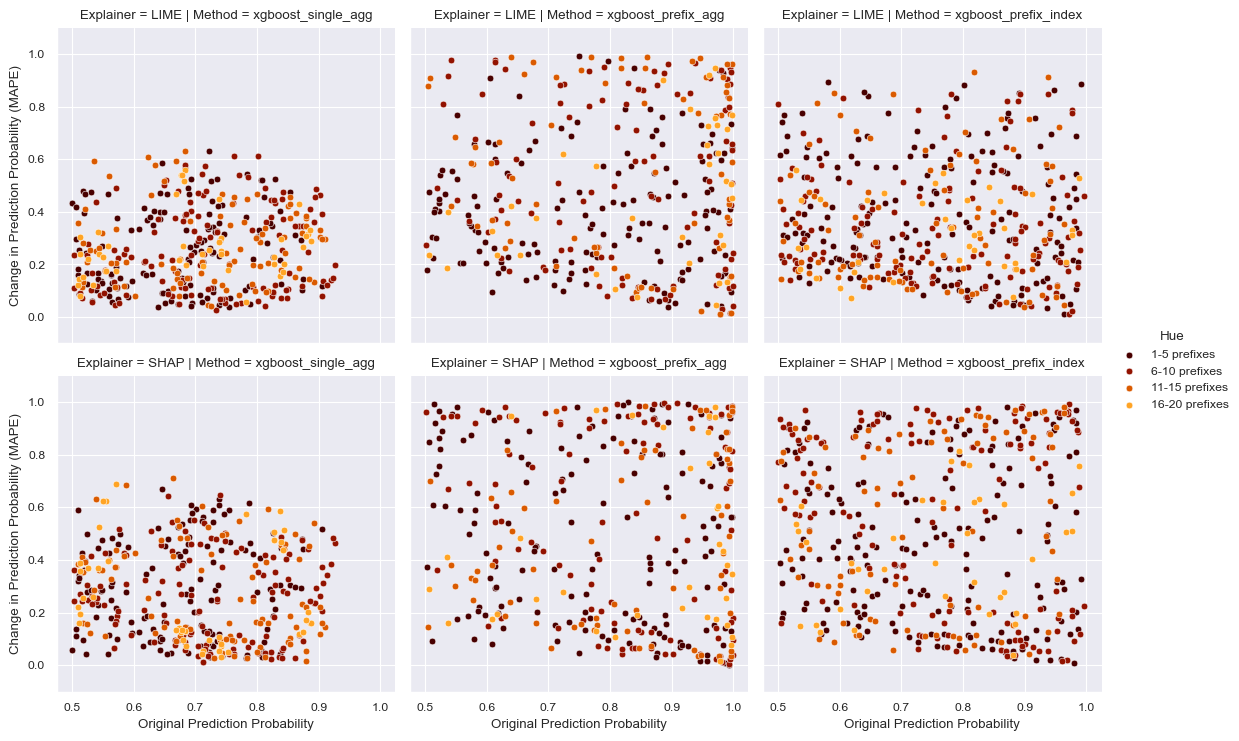

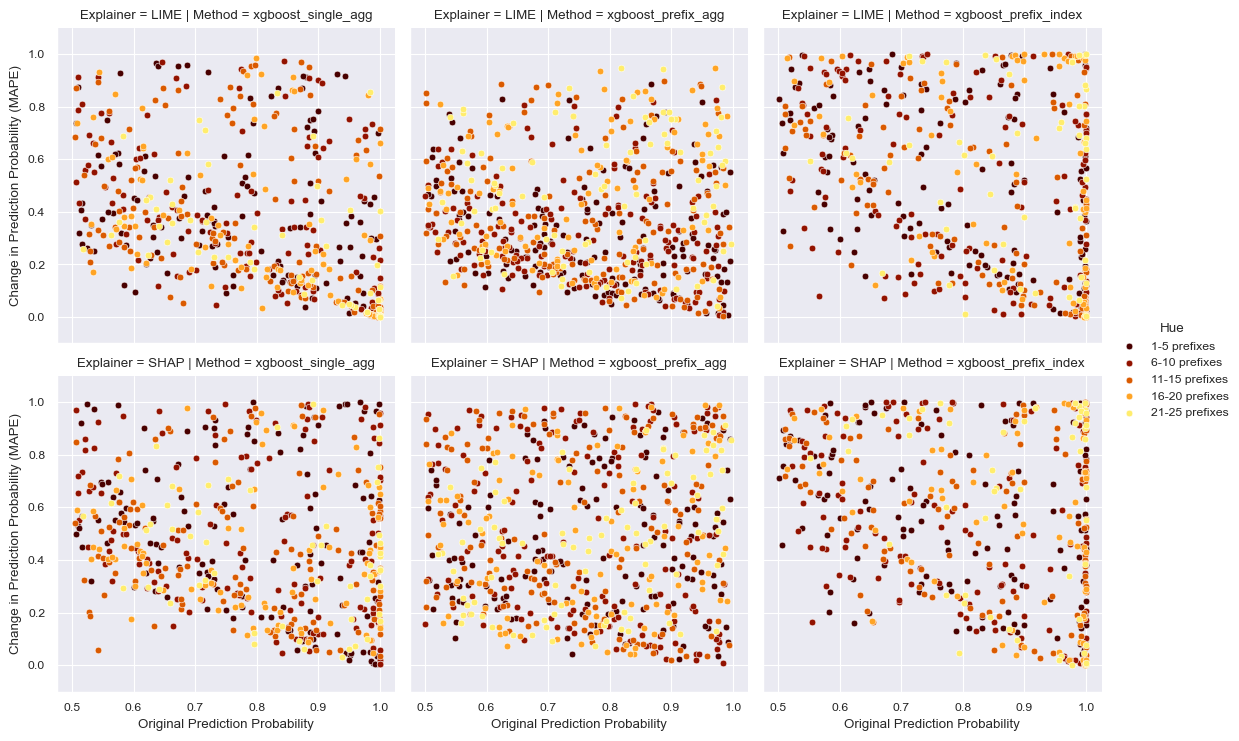

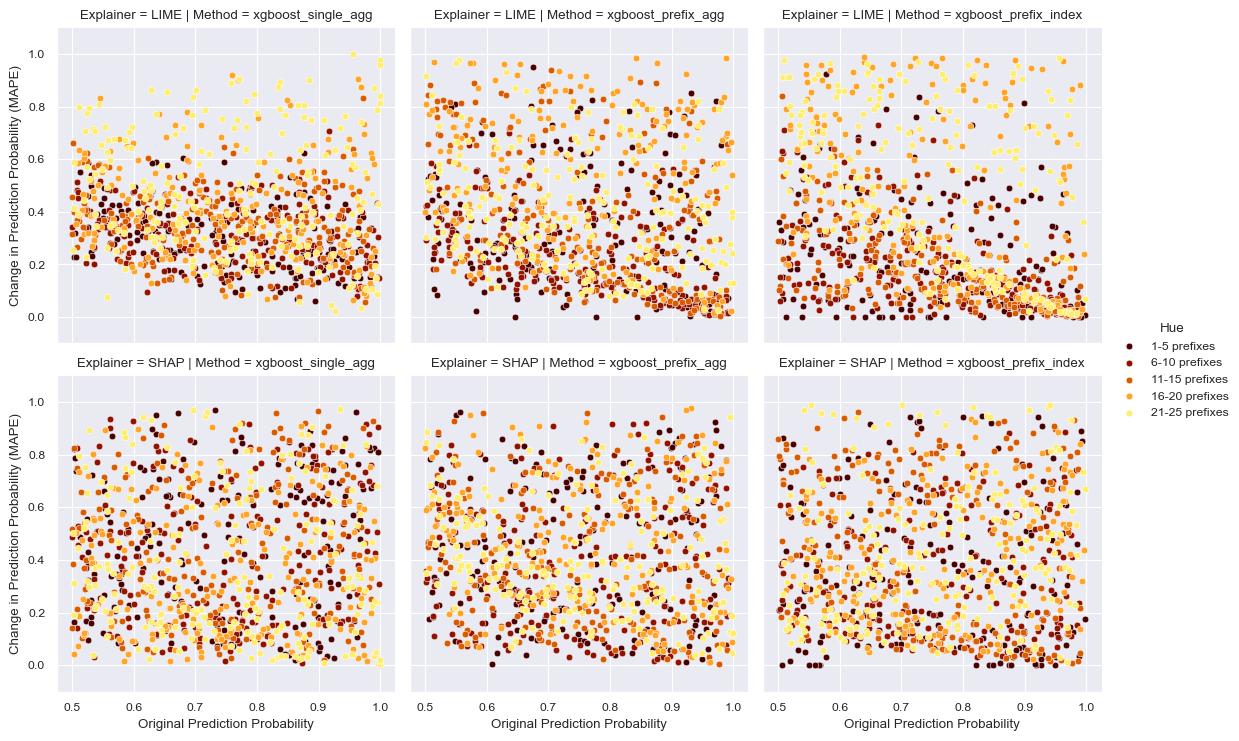

In [9]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
#methods = ["xgboost_prefix_index"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

sns.set_theme("paper", "darkgrid")
sns.set_palette("afmhot")

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_fidelity = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Fidelity": all_fidelity, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_fidelity = []
        tree_shap_fidelity = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                lime_diffs = pd.Series(results['lime_fid_change'])
                shap_diffs = pd.Series(results['shap_fid_change'])
                
                lime_mape = []
                shap_mape = []
                
                for j in range(len(lime_diffs)):
                    p1 = bucket_proba[j]
                    
                    lime_diff = lime_diffs[j]
                    shap_diff = shap_diffs[j]
                                        
                    lime_rel_changes = []
                    shap_rel_changes = []
                    
                    for each in lime_diff:
                        lime_rel_changes.append(abs(each)/p1)
                        
                    for each in shap_diff:
                        shap_rel_changes.append(abs(each)/p1)
                    
                    lime_mape.append(sum(lime_rel_changes)/len(lime_rel_changes))
                    shap_mape.append(sum(shap_rel_changes)/len(shap_rel_changes))

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_fidelity.extend(lime_mape)
                tree_shap_fidelity.extend(shap_mape)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))

        all_fidelity.extend(lime_fidelity)
        all_fidelity.extend(tree_shap_fidelity)

        avg_lime_fidelity = np.mean(lime_fidelity)
        avg_shap_fidelity = np.mean(tree_shap_fidelity)

        print("LIME:", avg_lime_fidelity)
        print("SHAP:", avg_shap_fidelity)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)

#sns.set_style('darkgrid')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 4, aspect = 1, palette = 'copper', ylim = (-1.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Stability")
# grid.set_axis_labels("Prediction Probability", "Stability")
# grid.add_legend()
plt.show()

for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    
    #sns.set_style('darkgrid')
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Fidelity")
    grid.set_axis_labels("Original Prediction Probability", "Change in Prediction Probability (MAPE)")
    grid.add_legend()
    plt.savefig("figures/"+data+"_fidelity.pdf", format="Pdf")
    plt.show()